# Calculation/compensation of the downwelling irradiance

In this section, we calculate the data of interest using Py6S for radiative transfer.

In [4]:
# Import all of the Py6S code
from Py6S import *

Running for many wavelengths - this may take a long time


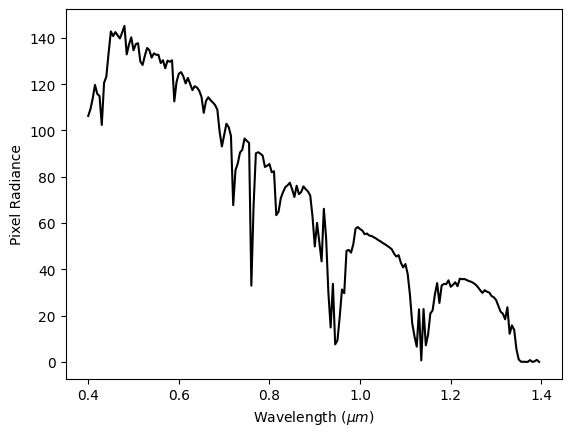

In [5]:
# Create a SixS object called s (used as the standard name by convention)
s = SixS()
# Run the 6S simulation defined by this SixS object across the
# whole VNIR range
wavelengths, results = SixSHelpers.Wavelengths.run_vnir(s, output_name="pixel_radiance")
# Plot these results, with the y axis label set to "Pixel Radiance"
SixSHelpers.Wavelengths.plot_wavelengths(wavelengths, results, "Pixel Radiance")

In [6]:
from Py6S import *
s = SixS()
s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.Tropical)
s.wavelength = Wavelength(0.357)
s.run()
print(s.outputs.pixel_radiance)
print(s.outputs.values)

59.344
{'version': '1.1', 'month': 7, 'day': 14, 'solar_z': 32, 'solar_a': 264, 'view_z': 23, 'view_a': 190, 'scattering_angle': 146.9, 'azimuthal_angle_difference': 74.0, 'visibility': 8.49, 'aot550': 0.5, 'ground_pressure': 1013.0, 'ground_altitude': 0.0, 'apparent_reflectance': 0.2316428, 'apparent_radiance': 59.344, 'total_gaseous_transmittance': 0.999, 'wv_above_aerosol': 0.232, 'wv_mixed_with_aerosol': 0.232, 'wv_under_aerosol': 0.232, 'apparent_polarized_reflectance': 0.0, 'apparent_polarized_radiance': 0.0, 'direction_of_plane_of_polarization': 0.0, 'total_polarization_ratio': 0.0, 'percent_direct_solar_irradiance': 0.335, 'percent_diffuse_solar_irradiance': 0.555, 'percent_environmental_irradiance': 0.11, 'atmospheric_intrinsic_reflectance': 0.0, 'background_reflectance': 0.0, 'pixel_reflectance': 0.232, 'direct_solar_irradiance': 208.329, 'diffuse_solar_irradiance': 344.735, 'environmental_irradiance': 68.389, 'atmospheric_intrinsic_radiance': 0.0, 'background_radiance': 0.0,

You can see here that we have changed the atmospheric profile to a pre-defined profile called ‘Tropical’, and changed the wavelength that we are using for the simulation to 0.357 micrometres. You can also see that here we’re accessing the outputs directly, rather than running it over a specific wavelength range and plotting it. Try finding out what other outputs you can access, by typing s.outputs. and pressing TAB.

In [7]:
# Some arbitrary values
s.atmos_profile = AtmosProfile.UserWaterAndOzone(3.6, 0.9) # Set the atmosphere profile to be based on 3.6cm of water and 0.9cm-atm of ozone
s.wavelength = Wavelength(PredefinedWavelengths.LANDSAT_TM_B3) # Set the wavelength to be that of the Landsat TM Band 3 - includes response function
s.ground_reflectance = GroundReflectance.HomogeneousWalthall(1.08, 0.48, 4.96, 0.5) # Set the surface to have a BRDF approximated by the Walthall model
s.geometry = Geometry.Landsat_TM()
s.geometry.month = 7
s.geometry.day = 14
s.geometry.gmt_decimal_hour = 7.75
s.geometry.latitude = 51.148
s.geometry.longitude = 0.307
s.run()
print(s.outputs.pixel_radiance)

248.337


Running for many wavelengths - this may take a long time
Running for many wavelengths - this may take a long time
Running for many wavelengths - this may take a long time
Running for many wavelengths - this may take a long time


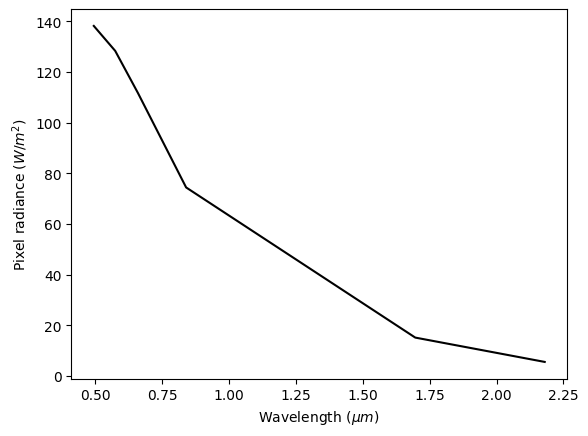

In [8]:
from Py6S import *
s = SixS()
# Run for the whole range of wavelengths that 6S supports
wv, res = SixSHelpers.Wavelengths.run_whole_range(s, output_name='pixel_radiance')
# Do the same, but at a coarser resolution, so that it's quicker
wv, res = SixSHelpers.Wavelengths.run_whole_range(s, spacing=0.030, output_name='pixel_radiance')
# Run for the Landsat TM bands
wv, res = SixSHelpers.Wavelengths.run_landsat_tm(s, output_name='pixel_radiance')

wv, res = SixSHelpers.Wavelengths.run_landsat_tm(s, output_name='pixel_radiance')
# Plot the results, setting the y-axis label appropriately
SixSHelpers.Wavelengths.plot_wavelengths(wv, res, 'Pixel radiance ($W/m^2$)')


# Read in the hyperspectral datacube of interest

In [9]:
import spectral as sp
import numpy as np

%matplotlib qt

# Find the spectral data cube of interest and display:
cube_path = r"D:\HyperspectralDataAll\HI\2022-08-31_1040_HSI\Output\GIS\HSIDatacubes\2022-08-31_1040_HSI_transectnr_6_chunknr_1_north_east.hdr"

spy_image_obj = sp.envi.open(cube_path)

spy_image_obj.bands.centers = np.array(spy_image_obj.metadata["wavelengths"]).astype(np.float64)

radiance = spy_image_obj[:,:,:] # Original Unit (mW/cm^2*sr*um)*1000.0000

L = (radiance / 1000) # Remove 1000 factor

L *= (1e-3 / 1e-4) # get power in W and area in m^2

L *= (1 / 1e3) # Get wavelengths unit from per micro to per nano meter.



# Read out wavelengths as these be needed for atmos correction
wl = np.array(spy_image_obj.metadata["wavelengths"]).astype(np.float64)
fwhm = np.array(spy_image_obj.metadata["fwhm"]).astype(np.float64)


In [10]:
# To give a simple estimate of reflectance, set the parameters in Py6s:
# Adapted from OpenHSI's atmos module which again is adapted from
import numpy as np
from datetime import datetime


# TODO: Put data from HSI here
wavelength_array = np.arange(390, 1100, 1)

wavelength_array = wavelength_array/1e3 # convert to μm for Py6S

s = SixS()



#s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.SubarcticSummer)


# TODO: Put flight time here
z_time = datetime.strptime("2022-08-31 08:40","%Y-%m-%d %H:%M") # Zulu datetime

lat = 62.25, # latitude in degrees
lon = 5.75, # longitude in degrees
zen = 0
azi = 0
alt = 80 / 10**3 # km

s.atmos_profile = AtmosProfile.FromLatitudeAndDate(lat, "2022-08-31")

#Viewing and sun geometry
s.geometry = Geometry.User()
s.geometry.day = z_time.day
s.geometry.month = z_time.month
dt_str = f"{z_time.year}-{z_time.month:02d}-{z_time.day:02d} {z_time.hour:02d}:{z_time.minute:02d}:{z_time.second:02d}"
s.geometry.from_time_and_location(lat, lon, dt_str, zen, azi)


#Altitude
s.altitudes = Altitudes()
s.altitudes.set_sensor_custom_altitude(alt) # km
s.altitudes.set_target_sea_level()
s.ground_reflectance = GroundReflectance.HomogeneousLambertian(1) # Ground reflectance for spectralon panel


# Aerosol
s.aero_profile = AeroProfile.PredefinedType(AeroProfile.Maritime)


TypeError: type tuple doesn't define __round__ method

In [ ]:
#Viewing and sun geometry
## From openhsi/atmos.py

import copy
from tqdm import tqdm
from multiprocessing.dummy import Pool

def _sixs_run_one_wavelength(s, wv:float) -> float:
    """Runs one instance of 6SV for one wavelength wv"""
    s.outputs = None
    a = copy.deepcopy(s)
    # TODO: Pass the wavelength filter
    a.wavelength = Wavelength(wv)
    a.run()
    return SixSHelpers.Wavelengths.recursive_getattr(a.outputs, "pixel_radiance")

def run_wavelengths(wavelengths:np.array, s, n_threads:int = 8) -> np.array:
    """Modified version of SixSHelpers.Wavelengths.run_wavelengths that has a progress bar.
    This implementation uses threading (through Python's multiprocessing API)."""
    
    
    with Pool(n_threads) as p, tqdm(total=len(wavelengths)) as pbar:
        res = [p.apply_async( _sixs_run_one_wavelength, args=(s, wavelengths[i],), 
                callback=lambda _: pbar.update(1)) for i in range(len(wavelengths))]
        results = [r.get() for r in res]
    
    return np.array(results)

radiances_simulated = run_wavelengths(wavelength_array, s) # units of (W/m^2/sr/μm)


  0%|          | 0/710 [00:00<?, ?it/s]

100%|██████████| 710/710 [00:55<00:00, 12.78it/s]


In [ ]:
# From ISTUTOR
def srf(x, mu, sigma):
     u = (x-mu)/abs(sigma)
     y = (1.0/(np.sqrt(2.0 * np.pi)*abs(sigma)))*np.exp(-u*u/2.0)
     return y/y.sum()


# Calculate spectral responses for all channels
radiances_resampled = []

cleaned_wavelength_array = wavelength_array[~np.isnan(radiances_simulated)]
cleaned_radiance = radiances_simulated[~np.isnan(radiances_simulated)]

for wavelength, width in zip(wl, fwhm):
    radiance_resampled = np.sum(srf(cleaned_wavelength_array*1e3, wavelength, width/2.3548) * cleaned_radiance)
    radiances_resampled.append(radiance_resampled)


print(np.nanmean(radiances_simulated))
print(np.nanmean(radiance_resampled))


155.7156225071225
99.71795083322243


In [ ]:
# Plot the data for sanity checking:
import matplotlib.pyplot as plt
print(np.array(fwhm).shape)
plt.plot(cleaned_wavelength_array*1e3, cleaned_radiance/10, label="computed radiance")
plt.plot(wl, np.array(radiances_resampled)/10, label="resampled radiance")
plt.xlabel("wavelength (nm)")
plt.ylabel('radiance (μW/cm$^2$/sr/nm)')

print(np.nanmax(radiance)) # For some reason one measurement that is wrong

(224,)
1.1315081e-08


In [ ]:


E_d_W_m2 = (np.array(radiances_resampled)/10)*(1e-6 / 1e-4) # W/m2


# Normalize data to get reflectance

In [ ]:
# 



"""# Select data of seagrass

Rrs = (L / E_d_W_m2).astype(np.float32)

Rrs[np.isnan(Rrs)] = -1

mm = spy_image_obj.open_memmap(writable=True)

R_iir = Rrs*np.pi
#
mm[:] = R_iir
#spy_image_obj[:,:, :] = Rrs

print(Rrs.astype(np.float32))

sp.imshow(R_iir, bands = (73, 50, 24))"""






[[[-3.2405434e-16            nan -9.1817783e-17 ... -2.8920013e-15
   -3.0072577e-15 -3.1348234e-15]
  [-3.2405434e-16            nan -9.1817783e-17 ... -2.8920013e-15
   -3.0072577e-15 -3.1348234e-15]
  [-3.2405434e-16            nan -9.1817783e-17 ... -2.8920013e-15
   -3.0072577e-15 -3.1348234e-15]
  ...
  [-3.2405434e-16            nan -9.1817783e-17 ... -2.8920013e-15
   -3.0072577e-15 -3.1348234e-15]
  [-3.2405434e-16            nan -9.1817783e-17 ... -2.8920013e-15
   -3.0072577e-15 -3.1348234e-15]
  [-3.2405434e-16            nan -9.1817783e-17 ... -2.8920013e-15
   -3.0072577e-15 -3.1348234e-15]]

 [[-3.2405434e-16            nan -9.1817783e-17 ... -2.8920013e-15
   -3.0072577e-15 -3.1348234e-15]
  [-3.2405434e-16            nan -9.1817783e-17 ... -2.8920013e-15
   -3.0072577e-15 -3.1348234e-15]
  [-3.2405434e-16            nan -9.1817783e-17 ... -2.8920013e-15
   -3.0072577e-15 -3.1348234e-15]
  ...
  [-3.2405434e-16            nan -9.1817783e-17 ... -2.8920013e-15
   -3.0072

c:\Users\haavasl\AppData\Local\miniconda3\envs\hyperspectral_full\lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Display bands       :  (73, 50, 24)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-3.4838033663161865e-16, 6.547490037497265e-16]
    G: [-1.3113061316742653e-16, 2.3996708093510346e-16]
    B: [-8.460996889999935e-17, 1.8402766190477997e-16]